# Ringed Seal Detector: 1 Sec, No Shift Augmentation

This notebook contains selections that were manually checked with no time augmentation (shifting). 

The results do not indicate overfitting. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## DO NOT RUN: Generate One Second, Not Centered Positive Selections

The negative selections were created previously and have been manually verified.

In [3]:
# Pathway to folder containing formatted complete annotation tables by site
formatted_annot_folder = r'C:\Users\kzammit\Documents\Detector\manual_dataset_build\formatted_annots'

# Get list of all csv files in that folder
files = glob.glob(formatted_annot_folder + "/*.csv")

# Set length of spectrogram to be 1 sec
length = 1.0

output_path = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots'

# For each csv file
for file in files:

    annots = pd.read_csv(file)
    std_annot = sl.standardize(table=annots, labels=["B", "BY"], start_labels_at_1=True, trim_table=True)
    std_annot['label'] = std_annot['label'].replace(2, 1)
    print('Training data standardized? ' + str(sl.is_standardized(std_annot)))

    # Step: Produce multiple selections for each annotated section by shifting the selection
    # window in steps of length step (in seconds) both forward and backward in
    # time. The default value is 0.

    # Min Overlap: Minimum required overlap between the selection and the annotated section, expressed
    # as a fraction of whichever of the two is shorter. Only used if step > 0.

    positives = sl.select(annotations=std_annot, length=length, step=1, min_overlap=1, center=False)

    new_file_name = output_path + '\\' + file.split('\\')[-1].split('.')[0] + '_1sec.csv'

    positives.to_csv(new_file_name)

Training data standardized? True
Training data standardized? True
Training data standardized? True
Training data standardized? True
Training data standardized? True


## DO NOT RUN: Plot Spectrograms

In [2]:
def load_audio_seg(annot_file, spec_file, data_dir):
    """
    Plot spectrograms for review
    :param annot_file: annotation file (xlsx)
    :param spec_file: spectrogram file
    :param data_dir: directory where data is stored (main level)
    :return:
    """

    annot = pd.read_csv(annot_file)

    # something up with loading in the spectro file
    f = open(spec_file)
    spec_info = json.load(f)
    rep = spec_info['spectrogram']

    # deal with merging of cells in the annotations table
    for ii in range(0, len(annot)):
        if type(annot.loc[ii][0]) == str:
            filename = annot.loc[ii][0]
        else:
            filename = annot['filename'][ii]

    # standardize tables
    annot = annot.ffill()
    annot_std = sl.standardize(table=annot)
    print('table standardized? ' + str(sl.is_standardized(annot_std)))

    # define spectrogram generation parameters
    spec_par = sl.select(annotations=annot_std, length=1.0, step=1, min_overlap=1, center=False)

    # create a generator for iterating over all the selections
    generator = SelectionTableIterator(data_dir=data_dir, selection_table=spec_par)

    # Create a loader by passing the generator and the representation to the AudioLoader
    loader = AudioLoader(selection_gen=generator, representation=MagSpectrogram, representation_params=rep, pad=False)

    # print number of segments
    print('Total number of segments is ' + str(loader.num()))
    annots = float(loader.num())

    return annots, loader


def plot_spectrogram(annot, loader, output_dir):
    """
    Plots spectrograms from an audioLoader item, call load_audio_seg first
    :param annot: annotation table returned from load_audio_seg
    :param loader: audioloader returned from load_audio_seg
    :param output_dir: output path to where you want the image saved
    :return:
    """

    for ii in range(0, int(annot)):
        spec = next(loader)
        fig = spec.plot()
        path = output_dir
        figname = path + "\\" + str(ii) + '.png'
        fig.savefig(figname)
        plt.close()

In [11]:
### Plot Spectrograms ###
annot_file = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\ULU2022_all_formatted_1sec.csv'
data_dir = r'D:\ringed-seal-data'
output_dir = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\spectrograms\ULU2022'
spec_file = r'C:\Users\kzammit\Documents\Detector\detector-1sec-timeShift\inputs\spec_config_1sec.json'

# create an audioloader with the spectrograms
# note you need to define step, maximum overlap, and length in this step
annot, loader = load_audio_seg(annot_file, spec_file, data_dir)

# take audio segments and create spectrogram representation
plot_spectrogram(annot, loader, output_dir)

print('done')

table standardized? True
Total number of segments is 1476


done


## Determine Sizes for Datasets

In [2]:
pos_folder = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\pos'

# Get list of all csv files in that folder
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals))
print('ulu vals (tr, va, te): ' + str(ulu_vals))
print('kk vals (tr, va, te): ' + str(kk_vals))
print('cb vals (tr, va, te): ' + str(cb_vals))

print('# of cb noise needed: ' + str(sum(cb_vals)))
print('# of ulu noise needed: ' + str(sum(ulu_vals)))
print('# of ulu22 noise needed: ' + str(sum(ulu2022_vals)))
print('# of kk noise needed: ' + str(sum(kk_vals)))

# additional noise samples
print('Need this many new noise samples per site: ')
print('CB: '+ str(sum(cb_vals) - 185))
print('KK: '+ str(sum(kk_vals) - 1749))
print('ULU: '+ str(sum(ulu_vals) - 901))
print('ULU22: '+ str(sum(ulu2022_vals) - 1362))

ulu22 vals (tr, va, te): [1037, 296, 143]
ulu vals (tr, va, te): [669, 191, 95]
kk vals (tr, va, te): [1348, 384, 192]
cb vals (tr, va, te): [133, 38, 19]
# of cb noise needed: 190
# of ulu noise needed: 955
# of ulu22 noise needed: 1476
# of kk noise needed: 1924
Need this many new noise samples per site: 
CB: 5
KK: 175
ULU: 54
ULU22: 114


## DO NOT RUN: Generate New Noise Segments

I need to generate and manually verify the above number of noise segments for each site. 

In [4]:
new_seg_folder = r"C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\negs-new"

file_durations_file = r'C:\Users\kzammit\Documents\Detector\manual_dataset_build\formatted_annots\all_file_durations_complete.xlsx'

file_durations = pd.read_excel(file_durations_file)

pos_folder = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\pos'

files_pos = glob.glob(pos_folder + "/*.csv")

for file in files_pos:

    annots = pd.read_csv(file)

    if 'CB' in file:
        num_negs = sum(cb_vals) - 185

    if 'ULU2022' in file:
        num_negs = sum(ulu2022_vals) - 1362

    if 'KK' in file:
        num_negs = sum(kk_vals) - 1749

    if 'ULU' in file and 'ULU2022' not in file:
        num_negs = sum(ulu_vals) - 901

    file_durations_train = file_durations[file_durations['filename'].isin(annots['filename'])]

    negatives = sl.create_rndm_selections(annotations=annots, files=file_durations_train,
                                                length=1.0, num=num_negs, trim_table=True)

    new_file_name = new_seg_folder + '\\' + file.split('\\')[-1].split('.')[0] + '_negatives.csv'

    negatives.to_csv(new_file_name)

### Plot Them

Note PP won't have an accurate number because the split wasn't calculated.

There are now 84 PP annotations and previously I had 71, so need to do 13 new noise segments.

In [9]:
### Plot Spectrograms ###
annot_file = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\negs-new\ulu_all_formatted_1sec_negatives.csv'
data_dir = r'D:\ringed-seal-data'
output_dir = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\negs-new\ulu'
spec_file = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\spec_config_1sec.json'

# create an audioloader with the spectrograms
# note you need to define step, maximum overlap, and length in this step
annot, loader = load_audio_seg(annot_file, spec_file, data_dir)

# take audio segments and create spectrogram representation
plot_spectrogram(annot, loader, output_dir)

print('done')

table standardized? True
Total number of segments is 54
done


## Initialize variables and dataset sizes

In [11]:
# Load in user inputs 
main_folder = r'C:\Users\kzammit\Documents\Detector\detector-1sec'

# These are copied from the 2sec edited folder 
neg_folder = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\negs-new\join'
pos_folder = r'C:\Users\kzammit\Documents\Detector\detector-1sec\inputs\annots\pos'

spec_file = main_folder + '\\' + r'inputs\spec_config_1sec.json'

data_folder = r'D:\ringed-seal-data'
db_name = main_folder + '\\' r'manual_database_1sec_20240116.h5'
recipe = main_folder + '\\' + r'inputs\resnet_recipe.json'
output_name = main_folder + '\\' + 'rs-1sec-20240115.kt'
temp_folder = main_folder + '\\' + 'rs-temp'

file_durations_file = r'C:\Users\kzammit\Documents\Detector\manual_dataset_build\formatted_annots' \
                      r'\all_file_durations_complete.xlsx'

file_durations = pd.read_excel(file_durations_file)

## Added more noise segments manually checked 

In [13]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [14]:
drop_rows_tr = []

print('cleaning training table of original length ' + str(len(train)))

for idex, row in train.iterrows():

    # filename is row[0], end time is idex.end
    index = file_durations.loc[file_durations['filename'] == row.name[0]].index
    duration = file_durations['duration'][index].values[0]

    if duration < row.end:
        # drop the row corresponding to that sel_id and filename from the dataframe
        drop_rows_tr.append(idex)

    if row.start < 0:
        drop_rows_tr.append(idex)

print('Number of dropped rows: ' + str(len(drop_rows_tr)))

train = train.drop(drop_rows_tr)
print(len(train))

cleaning training table of original length 6374
Number of dropped rows: 10
6362


In [15]:
drop_rows_va = []

print('cleaning validation table of original length ' + str(len(val)))

for idex, row in val.iterrows():

    # filename is row[0], end time is idex.end
    index = file_durations.loc[file_durations['filename'] == row.name[0]].index
    duration = file_durations['duration'][index].values[0]

    if duration < row.end:
        # drop the row corresponding to that sel_id and filename from the dataframe
        drop_rows_va.append(idex)

    if row.start < 0:
        drop_rows_va.append(idex)

print('Number of dropped rows: ' + str(len(drop_rows_va)))

val = val.drop(drop_rows_va)
print(len(val))

cleaning validation table of original length 1818
Number of dropped rows: 4
1813


In [16]:
drop_rows_te = []

print('cleaning test table of original length ' + str(len(test)))

for idex, row in test.iterrows():

    # filename is row[0], end time is idex.end
    index = file_durations.loc[file_durations['filename'] == row.name[0]].index
    duration = file_durations['duration'][index].values[0]

    if duration < row.end:
        # drop the row corresponding to that sel_id and filename from the dataframe
        drop_rows_te.append(idex)

    if row.start < 0:
        drop_rows_te.append(idex)

print('Number of dropped rows: ' + str(len(drop_rows_te)))

test = test.drop(drop_rows_te)
print(len(test))

cleaning test table of original length 898
Number of dropped rows: 2
894


In [17]:
train.to_excel(main_folder + '\\' + 'train_sel-20240116.xlsx')
val.to_excel(main_folder + '\\' + 'val_sel-20240116.xlsx')
test.to_excel(main_folder + '\\' + 'test_sel-20240116.xlsx')

In [18]:
#import tables
#tables.file._open_files.close_all()

Closing remaining open files:C:\Users\kzammit\Documents\Detector\detector-1sec\manual_database_1sec_20240116.h5...done


## Create Database

In [19]:
# join into a database

# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spec_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
# For the specific spectrogram in this case, the spectrograms are of size [1500,56] where 56 refers to the frequency dimension and 1500 refers to the time dimension 
# The size of the spectrogram is 1500*56, which is 84000
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:51<00:00, 37.05it/s]


6362 items saved to C:\Users\kzammit\Documents\Detector\detector-1sec\manual_database_1sec_20240116.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:44<00:00, 40.50it/s]


1813 items saved to C:\Users\kzammit\Documents\Detector\detector-1sec\manual_database_1sec_20240116.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:21<00:00, 41.24it/s]

894 items saved to C:\Users\kzammit\Documents\Detector\detector-1sec\manual_database_1sec_20240116.h5


## Train Classifier

In [20]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs'
checkpoint_folder = main_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=True, log_csv=True, csv_name='log.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(output_name, audio_repr_file=spec_file)


Epoch: 1 
train_loss: 0.3408821225166321
train_CategoricalAccuracy: 0.699 train_Precision: 0.720 train_Recall: 0.649 
val_loss: 0.37552642822265625
val_CategoricalAccuracy: 0.637 val_Precision: 0.580 val_Recall: 0.987 


Epoch: 2 
train_loss: 0.254070520401001
train_CategoricalAccuracy: 0.797 train_Precision: 0.815 train_Recall: 0.767 
val_loss: 0.257269024848938
val_CategoricalAccuracy: 0.863 val_Precision: 0.823 val_Recall: 0.925 


Epoch: 3 
train_loss: 0.2155892252922058
train_CategoricalAccuracy: 0.830 train_Precision: 0.866 train_Recall: 0.781 
val_loss: 0.2618720531463623
val_CategoricalAccuracy: 0.780 val_Precision: 0.882 val_Recall: 0.645 


Epoch: 4 
train_loss: 0.20110945403575897
train_CategoricalAccuracy: 0.839 train_Precision: 0.861 train_Recall: 0.807 
val_loss: 0.20418642461299896
val_CategoricalAccuracy: 0.830 val_Precision: 0.854 val_Recall: 0.796 


Epoch: 5 
train_loss: 0.1883348971605301
train_CategoricalAccuracy: 0.849 train_Precision: 0.878 train_Recall: 0.811 


## Evaluate

<Axes: xlabel='epoch', ylabel='loss'>

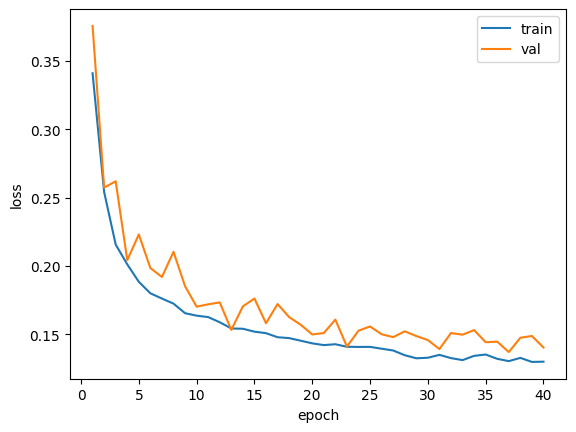

In [21]:
# Get path to folder containing logs 
log_folder = main_folder + '\\' + 'logs'

# Read the log file 
log_file = pd.read_csv(log_folder + '\\' + 'log.csv')

# Get the training and validation losses 
tr_results = log_file[log_file['dataset']=='train']
va_results = log_file[log_file['dataset']=='val']

# Plot the loss curves 
sns.lineplot(data=tr_results, x='epoch', y='loss', label='train', legend='auto')
sns.lineplot(data=va_results, x='epoch', y='loss', label='val', legend='auto')   

In [52]:
# Necessary for other steps 
test_filled = test.reset_index(allow_duplicates=True)

# Set pathway to audio folder 
audio_folder = main_folder + '\\' + 'audio'

# Copy files from main data folder into audio folder if they match the testing dataframe files 
for idex, row in test_filled.iterrows():
    shutil.copyfile(test_filled.loc[idex]['filename'], audio_folder + '\\' + test_filled.loc[idex]['filename'].split('\\')[-1])

print('done')

done


In [22]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [23]:
threshold = 0.5
step_size = 1.0
batch_size = 16
buffer = 0.5 

# Get pathway to metrics folder 
output_dir = main_folder + '\\' + 'metrics'

# Open the database in read only file 
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csvs = "classifications.csv"
metric_csvs = "metrics.csv"

# Load the trained model
model = ResNetInterface.load(output_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator 
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders 
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):

    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array 
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through 
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels 
scores = []
labels = []

# For each batch in the joint batch generator 
for batch_id in range(gen.n_batches):

    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment 
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches 
labels = np.array(labels)
scores = np.array(scores)

# Compute the predictions, TP, TN, FP, and FN
# Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not 
predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

print(f'\nSaving detections output to {output_dir}/')

# Create the "classifications" csv file 
df_group = pd.DataFrame()
for group in db.walk_nodes(table, "Table"):
    df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
    df_group = pd.concat([df_group, df], ignore_index=True)
df_group['label'] = labels[:]
df_group['predicted'] = predicted[:]
df_group['score'] = scores[:]
df_group.to_csv(os.path.join(os.getcwd(), output_dir, classification_csvs), mode='w', index=False)

# Calculate performance metrics 
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
FPP = FP / (TN + FP)

# Create a confusion matrix 
confusion_matrix = [[TP, FN], [FP, TN]]

# Print the results 
print(f'\nPrecision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('\nConfusionMatrix:')
print('\n[TP, FN]')
print('[FP, TN]')
print(f'{confusion_matrix[0]}')
print(f'{confusion_matrix[1]}')

# Save to an excel file 
print(f"\nSaving metrics to {output_dir}/")

# Saving precision recall and F1 Score for the defined thrshold
metrics = {'Precision': [precision], 'Recall': [recall], "F1 Score": [f1]}
metrics_df = pd.DataFrame(data=metrics)

metrics_df.to_csv(os.path.join(os.getcwd(), output_dir, metric_csvs), mode='w', index=False)

# Appending a confusion matrix to the file
row1 = ["Confusion Matrix", "Predicted"]
row2 = ["Actual", "RS", "Noise"]
row3 = ["RS", TP, FN]
row4 = ["Noise", FP, TN]
with open(os.path.join(os.getcwd(), output_dir, metric_csvs), 'a', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow([])
    writer.writerow(row1)
    writer.writerow(row2)
    writer.writerow(row3)
    writer.writerow(row4)
    
db.close()


Saving detections output to C:\Users\kzammit\Documents\Detector\detector-1sec\metrics/

Precision: 0.8790123456790123
Recall: 0.796420581655481
F1 Score: 0.8356807511737089

ConfusionMatrix:

[TP, FN]
[FP, TN]
[356, 91]
[49, 398]

Saving metrics to C:\Users\kzammit\Documents\Detector\detector-1sec\metrics/


In [24]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('no title')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

no title


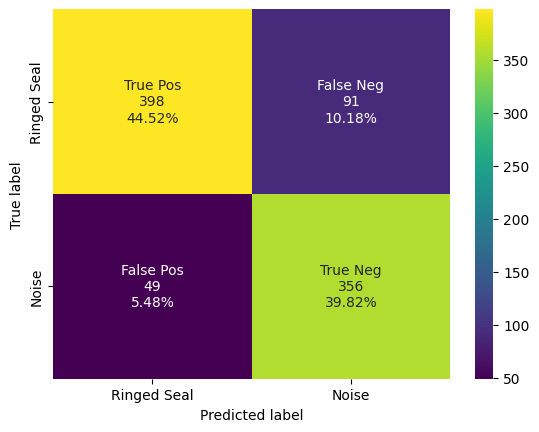

In [25]:
classifications_file = r'C:\Users\kzammit\Documents\Detector\detector-1sec\metrics\classifications.csv'

classifications = pd.read_csv(classifications_file)

predictions = classifications['predicted']

labels = classifications['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

In [47]:
# Set the temp folder, detections csv, detections threshold, step size, batch size, and buffer 

audio_folder = main_folder + '\\' + 'audio'

temp_folder = main_folder + '\\' + 'ringedS_tmp_folder'

detections_csv = main_folder + '\\' + 'detections_raw.csv'

threshold = 0.5
step_size = 1.0
batch_size = 16
buffer = 0.5 

# Load the already trained model file 
model = ResNetInterface.load(model_file=output_name, new_model_folder=temp_folder)

# Load the audio representation (dict)
audio_repr = load_audio_representation(path=spec_file)

# Get the config from the "spectrogram" audio representation
# This is helpful if I had "waveform" as well in the representation options as well 
spec_config = audio_repr['spectrogram']

# Create an audioFrameLoader containing the spectrogram parameters and type 
audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)

# Initialize a detections dataframe 
detections = pd.DataFrame()

# Load the audio data in the defined batch size with the audio loader object 
batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

# for each batch
for batch_data in batch_generator:
    
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    # Filter the raw detections by the threshold, dropping detections below the threshold 
    # will be a dataframe with the filename, start, end, label, and score 
    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    # Add these detections to the detections dataframe 
    detections = pd.concat([detections, batch_detections], ignore_index=True)

# Output the detections that were over a threshold to a csv file
detections.to_csv(detections_csv, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 3959/3959 [06:13<00:00, 10.61it/s]
